In [0]:
from fastai.utils.show_install import *
show_install()

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [0]:
printm() 

Gen RAM Free: 21.6 GB  | Proc size: 6.9 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
#!pip install tensorflow-addons

In [0]:
from google.colab import drive
drive.mount('/content/drive')
! rm -r /content/sample_data
! cp -a '/content/drive/My Drive/cityscapes/.' '/content'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install tensorflow-gpu==2.1

# Data

In [0]:
%tensorflow_version 2.x
%load_ext tensorboard
import tensorflow as tf
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import skimage
from tensorflow.keras import backend, layers, models
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from collections import namedtuple

# Taken from cityscapesscripts\helpers\labels.py
Label = namedtuple( 'Label' , [
    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class
    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.
    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!
    'category'    , # The name of the category that this label belongs to
    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.
    'hasInstances', # Whether this label distinguishes between single instances or not
    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not
    'color'       , # The color of this label
    ] )
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
LABEL_DICTIONARY   = { label.trainId : label for label in reversed(labels) }

TensorFlow 2.x selected.


Creating data-pipeline

In [0]:
CLASSES = 20 # trainId from 0 to 18 + unlabeled 255 as 19
IMAGE_WIDTH = 2048
IMAGE_HEIGHT = 1024
BATCH_SIZE = 3
FINE_TRAIN_DATASET_SIZE = 2975
COARSE_TRAIN_DATASET_SIZE = 20000
VAL_DATASET_SIZE = 500

def color_mask(grayscale_mask):
  def grayscale_value_to_rgb_tuple(pixel): 
    if pixel >= CLASSES-1:
      pixel = 255
    rgb_tuple = LABEL_DICTIONARY[pixel].color
    return rgb_tuple
  fun = np.vectorize(grayscale_value_to_rgb_tuple)
  rgb_tuple_mask = fun(grayscale_mask)
  color_mask = np.dstack([rgb_tuple_mask[0], rgb_tuple_mask[1], rgb_tuple_mask[2]])
  return color_mask.astype(np.uint8)

@tf.function
def augmentation(input_image, true_mask):
  stacked_image = tf.keras.backend.concatenate([input_image, true_mask], axis=2)
  #if tf.random.uniform(()) < 0.99:
  #  angle = tf.random.uniform(minval=-0.05, maxval=0.05, dtype=tf.dtypes.float32, shape=[])
  #  stacked_image = tfa.image.rotate(stacked_image, angle, interpolation='NEAREST', name=None)
  if tf.random.uniform(()) < 0.50:
    zoom = tf.random.uniform(minval=0.75, maxval=1.0, dtype=tf.dtypes.float32, shape=[])
    stacked_image = tf.image.random_crop(stacked_image, size=[IMAGE_HEIGHT*zoom, IMAGE_WIDTH*zoom, 4])
    stacked_image = tf.image.resize(stacked_image, [IMAGE_HEIGHT, IMAGE_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  if tf.random.uniform(()) < 0.50:
    stacked_image = tf.image.flip_left_right(stacked_image)
  input_image = stacked_image[:,:,0:3]
  true_mask = stacked_image[:,:,3:4]
  return input_image, true_mask

@tf.function
def normalize(input_image, true_mask):
  true_mask = tf.cast(true_mask, tf.float32)
  # Clip 0-255 -> 0-19
  true_mask = tf.clip_by_value(true_mask, clip_value_min=0, clip_value_max=CLASSES-1) 
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, true_mask

def parse_example_function(example_proto):
  """Dekodowanie danych z TFRecords"""
  feature_description = {
    'image/encoded': tf.io.FixedLenFeature((), tf.string, default_value=''),
    'image/filename': tf.io.FixedLenFeature((), tf.string, default_value=''),
    'image/format': tf.io.FixedLenFeature((), tf.string, default_value='jpeg'),
    'image/height': tf.io.FixedLenFeature((), tf.int64, default_value=0),
    'image/width': tf.io.FixedLenFeature((), tf.int64, default_value=0),
    'image/segmentation/class/encoded': tf.io.FixedLenFeature((), tf.string, default_value=''),
    'image/segmentation/class/format': tf.io.FixedLenFeature((), tf.string, default_value='png'),
  }
  return tf.io.parse_single_example(example_proto, feature_description)

@tf.function
def parse_function(example, data_augmentation):
  parsed_example = parse_example_function(example)
  input_image = tf.io.decode_jpeg(parsed_example['image/encoded'], channels=3)
  true_mask = tf.io.decode_png(parsed_example['image/segmentation/class/encoded'], channels=1) 
  if data_augmentation==True:
    input_image, true_mask = augmentation(input_image, true_mask)
  input_image, true_mask = normalize(input_image, true_mask)
  return input_image, true_mask

def make_dataset(file_pattern, batch_size, data_augmentation=True):
  files = tf.data.Dataset.list_files(file_pattern=file_pattern)
  dataset = tf.data.TFRecordDataset(files)
  if data_augmentation:
    dataset = dataset.shuffle(buffer_size=FINE_TRAIN_DATASET_SIZE)
  dataset = dataset.map(lambda example: parse_function(example, data_augmentation), num_parallel_calls=2)
  dataset = dataset.batch(batch_size=batch_size).repeat()
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

validation_dataset = make_dataset('val-fine-0000*-of-00002.tfrecord', BATCH_SIZE, data_augmentation=False)
#train_coarse_dataset = make_dataset('train-coarse-0000*-of-00002.tfrecord', BATCH_SIZE, data_augmentation=True)
train_fine_dataset = make_dataset('train-fine-0000*-of-00002.tfrecord', BATCH_SIZE, data_augmentation=True)

Reading 3 examples from data pipeline



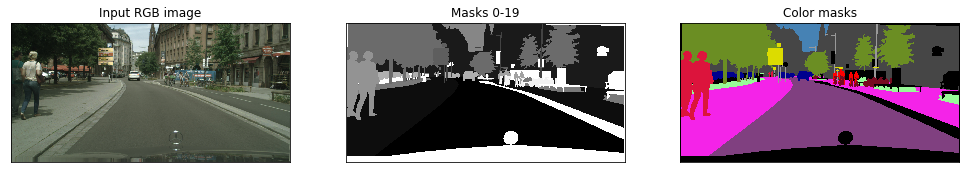

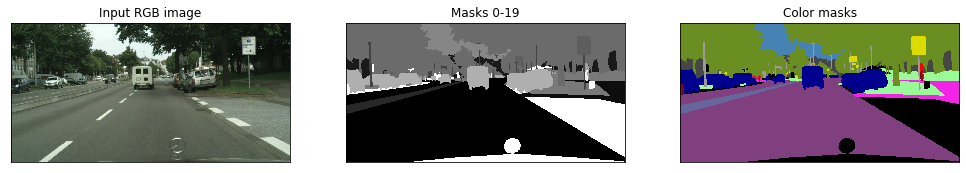

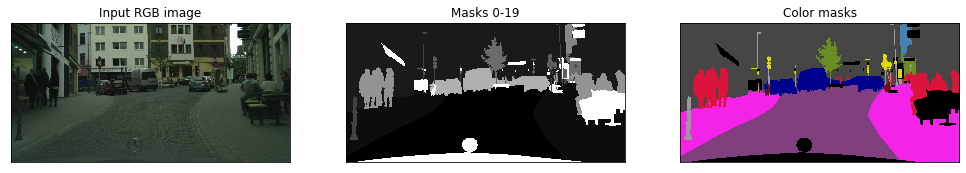

In [0]:
for example in train_fine_dataset.take(3):
  fig = plt.figure(figsize=(17,20))
  plt.subplot(1,3,1)
  plt.title('Input RGB image')
  plt.xticks([])
  plt.yticks([])
  plt.imshow(example[0][0])
  plt.subplot(1,3,2)
  plt.title('Masks 0-19')
  plt.xticks([])
  plt.yticks([])
  true_mask = example[1][0,:,:,0]
  plt.imshow(true_mask, cmap='gray')
  plt.subplot(1,3,3)
  plt.title('Color masks')
  plt.xticks([])
  plt.yticks([])
  color_true_mask = color_mask(true_mask)
  plt.imshow(color_true_mask) 
  plt.show()

Compute the class weights

In [0]:
"""
def make_dataset_for_weighting(file_pattern):
  files = tf.data.Dataset.list_files(file_pattern=file_pattern)
  dataset = tf.data.TFRecordDataset(files)
  dataset = dataset.map(lambda example: parse_function(example, False), num_parallel_calls=2)
  dataset = dataset.batch(batch_size=1)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

dataset_for_weighting = make_dataset_for_weighting('train-fine-0000*-of-00002.tfrecord')

trainId_to_count = {}
for trainId in range(CLASSES):
    trainId_to_count[trainId] = 0

for index in range(0, FINE_TRAIN_DATASET_SIZE):
  print("Processing: ", index)

  # get the total number of pixels in all train label_imgs that are of each object class:
  for example in dataset_for_weighting.take(1):
    true_mask = example[1][0,:,:,0]
    plt.imshow(true_mask, cmap='gray')

    for trainId in range(CLASSES):
      trainId_mask = np.equal(true_mask, trainId)
      trainId_to_count[trainId] += np.sum(trainId_mask)

# compute the class weights according to the ENet paper:
class_weights = []
total_count = sum(trainId_to_count.values())
for trainId, count in trainId_to_count.items():
    trainId_prob = float(count)/float(total_count)
    trainId_weight = 1/np.log(1.02 + trainId_prob)
    class_weights.append(trainId_weight)

print (class_weights) """

# Models

## Unet MobileNet V2  (val. acc 0.91, val. mIOU 0.60)

Big and slow model due to Conv2DTranspose, which takes up most of the computational time.



In [0]:
# MobileNetv2: https://arxiv.org/pdf/1801.04381.pdf

feature_extractor = tf.keras.applications.MobileNetV2(input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], include_top=False, alpha=1.0)
output_layer_names = [
    'block_1_expand_relu', # None, 1024, 512, 96 -> level 2
    'block_3_expand_relu', # None, 512, 256, 144 -> level 3
    'block_6_expand_relu', # None, 256, 128, 192 -> level 4
    'block_13_expand_relu',# None, 128, 64, 576 -> level 5
    'block_16_project',    # None, 64, 32, 320 -> level 6
]
feature_extractor_output_layers = [feature_extractor.get_layer(name).output for name in output_layer_names]

def upsample(filters, activation=None, last=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, kernel_size=(3,3), strides=2, padding='same', 
                                             kernel_initializer=initializer, use_bias=False, activation=activation))
  if not last:
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())
  return result

Top-down
level6 = feature_extractor_output_layers[-1]
level5 = upsample(filters=512)(level6)
level5 = tf.keras.layers.concatenate([level5, feature_extractor_output_layers[-2]])
level4 = upsample(filters=256)(level5)
level4 = tf.keras.layers.concatenate([level4, feature_extractor_output_layers[-3]])
level3 = upsample(filters=128)(level4)
level3 = tf.keras.layers.concatenate([level3, feature_extractor_output_layers[-4]])
level2 = upsample(filters=64)(level3)
level2 = tf.keras.layers.concatenate([level2, feature_extractor_output_layers[-5]])
output_layer = upsample(filters=CLASSES, activation='softmax', last=True)(level2)

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model = tf.keras.Model(inputs=feature_extractor.input, outputs=output_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', MeanIoU(num_classes=CLASSES, name='mIOU')])

model.summary(line_length=150)
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='Unet MobileNet V2.png')

## Lite RASPP Large MobileNet V3 (val. acc. 0.84 val. mIOU 0.37)


![alt text](https://camo.githubusercontent.com/a07fc07bdc037f125e0e6671edbc32d26c33edcc/68747470733a2f2f692e696d6775722e636f6d2f397757453647502e706e67)

![alt text](https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/image/1095279435121/1095279435121_1570531639002.jpg)

MobileNet V3 paper: https://arxiv.org/pdf/1905.02244v4.pdf

In [0]:
class MobileNetV3LiteRASPP:
  def __init__(self, shape, n_class):
    self.shape = shape
    self.n_class = n_class

  def build_large(self):
    inputs = layers.Input(shape=self.shape)
    x = layers.Conv2D(16, (3, 3), padding="same", strides=(2, 2), use_bias=False)(inputs)
    x = layers.BatchNormalization(axis=-1)(x)
    x = self._activation(x, "HS")
    # Bottleneck blocks like in https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet_v3.py
    x,   _, _, _ = self._bneck(x, 16, (3, 3), expansion=16*1, strides=1, rate=1, squeeze=False, at="RE")
    x,   _, _, _ = self._bneck(x, 24, (3, 3), expansion=24*4, strides=2, rate=1, squeeze=False, at="RE")
    x,   _, _, _ = self._bneck(x, 24, (3, 3), expansion=24*3, strides=1, rate=1, squeeze=False, at="RE")
    x,   _, _, _ = self._bneck(x, 40, (5, 5), expansion=40*3, strides=2, rate=1, squeeze=True, at="RE")
    x,   _, _, _ = self._bneck(x, 40, (5, 5), expansion=40*3, strides=1, rate=1, squeeze=True, at="RE")
    x,   _, _, _ = self._bneck(x, 40, (5, 5), expansion=40*3, strides=1, rate=1, squeeze=True, at="RE")
    x, LLF, _, _ = self._bneck(x, 80, (3, 3), expansion=80*6, strides=2, rate=1, squeeze=False, at="HS") # C3
    x,   _, _, _ = self._bneck(x, 80, (3, 3), expansion=80*2.5, strides=1, rate=1, squeeze=False, at="HS")
    x,   _, _, _ = self._bneck(x, 80, (3, 3), expansion=80*2.3, strides=1, rate=1, squeeze=False, at="HS")
    x,   _, _, _ = self._bneck(x, 80, (3, 3), expansion=80*2.3, strides=1, rate=1, squeeze=False, at="HS")
    x,   _, _, _ = self._bneck(x, 112, (3, 3), expansion=112*6, strides=1, rate=1, squeeze=True, at="HS")
    x,   _, _, _ = self._bneck(x, 112, (3, 3), expansion=112*6, strides=1, rate=1, squeeze=True, at="HS")
    # Atrous convolution instead stride 2
    x,   _, _, _ = self._bneck(x, 160, (5, 5), expansion=int(160*6/2), strides=1, rate=2, squeeze=True, at="HS") # C4
    x,   _, _, _ = self._bneck(x, 160, (5, 5), expansion=int(160*6/2), strides=1, rate=2, squeeze=True, at="HS")
    x,   _, _, _ = self._bneck(x, 160, (5, 5), expansion=int(160*6/2), strides=1, rate=2, squeeze=True, at="HS") 
    x = layers.Conv2D(int(960/2), (1, 1), padding="same", strides=(1, 1), use_bias=False)(x)
    HLF = self._activation(x, "HS") # C5

    x = self._segmentation_head(HLF, LLF)
    model = models.Model(inputs, x, name="MobileNetV3LiteRASPP")
    return model

  def _bneck(self, x, filters, kernel, expansion, strides, rate, squeeze, at):
    x_copy = x
    input_shape = backend.int_shape(x)
    tchannel = int(expansion)
    cchannel = int(filters)
    r = strides == 1 and input_shape[3] == filters
    # Expansion convolution
    exp_x = layers.Conv2D(tchannel, (1, 1), padding="same", strides=(1, 1), use_bias=False)(x)
    exp_x = layers.BatchNormalization(axis=-1)(exp_x)
    exp_x = self._activation(exp_x, at)
    # Depthwise convolution
    dep_x = layers.DepthwiseConv2D(kernel, strides=(strides, strides), dilation_rate=(rate, rate), depth_multiplier=1, padding="same", use_bias=False)(exp_x)
    dep_x = layers.BatchNormalization(axis=-1)(dep_x)
    #dep_x = self._activation(dep_x, at)
    # Squeeze
    if squeeze:
        dep_x = self._squeeze(dep_x)
    dep_x = self._activation(dep_x, at)
    # Projection convolution
    pro_x = layers.Conv2D(cchannel, (1, 1), strides=(1, 1), padding="same", use_bias=False)(dep_x)
    pro_x = layers.BatchNormalization(axis=-1)(pro_x)
    x = pro_x
    if r:
        x = layers.Add()([pro_x, x_copy])
    return x, exp_x, dep_x, pro_x

  def _squeeze(self, x):
    x_copy = x
    channel = backend.int_shape(x)[-1]
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(channel//4, activation="relu", kernel_initializer='he_normal', use_bias=False)(x)
    x = layers.Dense(channel, activation="hard_sigmoid", kernel_initializer='he_normal', use_bias=False)(x)
    x = layers.Reshape((1, 1, channel))(x)
    x = layers.Multiply()([x_copy, x])
    return x

  def _segmentation_head(self, x_16, x_8):
    x_copy = x_16
    input_size = x_16.shape
    # First branch
    x_b1 = layers.Conv2D(128, (1, 1), strides=(1, 1), padding="same", use_bias=False)(x_16)
    # This is the size we want for the other branch
    sh = x_b1.shape
    x_b1 = layers.BatchNormalization(axis=-1)(x_b1)
    x_b1 = self._activation(x_b1, at="RE")
    # Second branch
    x_b2 = layers.AveragePooling2D(pool_size=(49,49), strides=(16,16), padding='same')(x_16)
    x_b2 = layers.Conv2D(128, (1, 1), use_bias=False)(x_b2)
    x_b2 = layers.Activation("sigmoid")(x_b2)
    x_b2 = layers.UpSampling2D(16, interpolation="bilinear")(x_b2)
    # Merging branches 1 and 2
    x = layers.Multiply()([x_b1, x_b2])
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(self.n_class, (1, 1), use_bias=False)(x)
    x_b3 = layers.Conv2D(self.n_class, (1, 1), use_bias=False)(x_8)
    # Merging merge 1 and branche 3
    x = layers.Add()([x, x_b3])
    
    x = layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(x)
    x = layers.Activation("softmax")(x)
    return x

  def _activation(self, x, at):
    if at == "RE":
        x = backend.relu(x, max_value=6) # ReLU6
    else:
        x = x * backend.relu(x, max_value=6) / 6 # Hard swish
    return x

mnv3_lite_raspp = MobileNetV3LiteRASPP(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), n_class=CLASSES)
model = mnv3_lite_raspp.build_large()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=CLASSES, name='mIOU')])

model.summary(line_length=150)
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='MobileNetV3 LiteRASPP.png')

## Lite RASPP Large MobileNet V2 (val. acc. 0.90 val. mIOU 0.60)


In [0]:
def segmentation_head(x_16, x_8):
  x_copy = x_16
  input_size = x_16.shape
  # First branch
  x_b1 = layers.Conv2D(128, (1, 1), strides=(1, 1), padding="same", use_bias=False)(x_16)
  # This is the size we want for the other branch
  sh = x_b1.shape
  x_b1 = layers.BatchNormalization(axis=-1)(x_b1)
  x_b1 = layers.Activation("relu")(x_b1)
  # Second branch
  x_b2 = layers.AveragePooling2D(pool_size=(49,49), strides=(16,16), padding='same')(x_16)
  x_b2 = layers.Conv2D(128, (1, 1), use_bias=False)(x_b2)
  x_b2 = layers.Activation("sigmoid")(x_b2)
  x_b2 = layers.UpSampling2D(16, interpolation="bilinear")(x_b2)
  # Merging branches 1 and 2
  x = layers.Multiply()([x_b1, x_b2])
  x = layers.UpSampling2D(4)(x)
  x = layers.Conv2D(CLASSES, (1, 1), use_bias=False)(x)
  x_b3 = layers.Conv2D(CLASSES, (1, 1), use_bias=False)(x_8)
  # Merging merge 1 and branche 3
  x = layers.Add()([x, x_b3])
  
  x = layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(x)
  x = layers.Activation("softmax")(x)
  return x

feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,3), include_top=False, alpha=1.0)

LLF = feature_extractor.get_layer('block_6_expand_relu').output # 256x128
HLF = feature_extractor.get_layer('block_16_project').output # 64x32
output_layer = segmentation_head(HLF, LLF)
model = tf.keras.Model(inputs=feature_extractor.input, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=CLASSES, name='mIOU')])

model.summary(line_length=150)
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='MobileNetV2 LiteRASPP.png')

/tensorflow-2.1.0/python3.6/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_4 (InputLayer)                             [(None, 1024, 2048, 3)]          0                                                                   
______________________________________________________________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)                        (None, 1025, 2049, 3)            0                 input_4[0][0]                                     
______________________________________________________________________________________________________________________________________________________
Conv1 (Conv2D)                                   (None, 512, 1024, 32)         

## DeepLab V3+ Xception 41 (val. acc. 0.87, val. mIOU 0.52)





Paper: https://arxiv.org/abs/1802.02611

Xception 65 and 41 does not fit in the 16GB VRAM, so I used Xception 41 with smaller number of channels and blocks. 

Batch size = 1

Atrous Spatial Pyramid Pooling - from top to bottom B0-B4 maps
![alt text](https://miro.medium.com/max/1121/0*nnPrlrQAt0bDzIWF)


Xception 65

![alt text](http://lijiancheng0614.github.io/2018/02/27/2018_02_27_DeepLab-v3+/figure3.png)

In [0]:
"""
Taken from:
https://github.com/bonlime/keras-deeplab-v3-plus/blob/master/model.py
"""
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Activation, Concatenate, Add, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.utils import get_source_inputs, get_file
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu

def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    return x

def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)

def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs

def Deeplabv3(input_shape=(1024, 2048, 3), classes=20, OS=8):
    """ Instantiates the Deeplabv3+ architecture
    # Arguments
        input_shape: shape of input image. format HxWxC
        classes: number of desired classes. 
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    img_input = Input(shape=input_shape)
    if OS == 8:
        entry_block3_stride = 1
        middle_block_rate = 2  # Not mentioned in paper, but required
        exit_block_rates = (2, 4)
        atrous_rates = (12, 24, 36)
    else:
        entry_block3_stride = 2
        middle_block_rate = 1
        exit_block_rates = (1, 2)
        atrous_rates = (6, 12, 18)

    x = Conv2D(32, (3, 3), strides=(2, 2), name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
    x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
    x = Activation('relu')(x)

    x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
    x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
    x = Activation('relu')(x)
    
    # Original Xception 65

    # x = _xception_block(x, [128, 128, 128], 'entry_flow_block1', skip_connection_type='conv', stride=2, depth_activation=False)
    # x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2', skip_connection_type='conv', stride=2,
    #                             depth_activation=False, return_skip=True)
    # x = _xception_block(x, [728, 728, 728], 'entry_flow_block3', skip_connection_type='conv', stride=entry_block3_stride,
    #                     depth_activation=False)
    # for i in range(16):
    #     x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1), 
    #                         skip_connection_type='sum', stride=1, rate=middle_block_rate,
    #                         depth_activation=False)
    # x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1', skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
    #                     depth_activation=False)
    # x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2', skip_connection_type='none', stride=1, rate=exit_block_rates[1],
    #                     depth_activation=True)
    
    # Simplified Xception 41

    x = _xception_block(x, [64, 64, 64], 'entry_flow_block1', skip_connection_type='conv', stride=2, depth_activation=False)
    x, skip1 = _xception_block(x, [128, 128, 128], 'entry_flow_block2', skip_connection_type='conv', stride=2,
                                depth_activation=False, return_skip=True)
    x = _xception_block(x, [364, 364, 364], 'entry_flow_block3', skip_connection_type='conv', stride=entry_block3_stride,
                        depth_activation=False)
    for i in range(6): # 16 blocks = Xception 65, 8 blocks = Xception 41 
        x = _xception_block(x, [364, 364, 364], 'middle_flow_unit_{}'.format(i + 1), 
                            skip_connection_type='sum', stride=1, rate=middle_block_rate,
                            depth_activation=False)
    x = _xception_block(x, [364, 512, 512], 'exit_flow_block1', skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                        depth_activation=False)
    x = _xception_block(x, [768, 768, 1024], 'exit_flow_block2', skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                        depth_activation=True)
    
    # branching for Atrous Spatial Pyramid Pooling
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    b4 = K.expand_dims(b4, 1)
    b4 = K.expand_dims(b4, 1)
    b4 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='image_pooling')(b4)
    #b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-3)(b4) # Batch normalization creates error with batch size = 1
    b4 = Activation('relu')(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3], method='bilinear', align_corners=True))(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)
    # rate = 6 (12)
    b1 = SepConv_BN(x, 256, 'aspp1', rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
    # rate = 12 (24)
    b2 = SepConv_BN(x, 256, 'aspp2', rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
    # rate = 18 (36)
    b3 = SepConv_BN(x, 256, 'aspp3', rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

    # concatenate ASPP branches & project
    x = Concatenate()([b4, b0, b1, b2, b3])
    x = Conv2D(256, (1, 1), padding='same', use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    # DeepLab v.3+ decoder
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx, skip1.shape[1:3], method='bilinear', align_corners=True))(x)
    dec_skip1 = Conv2D(48, (1, 1), padding='same', use_bias=False, name='feature_projection0')(skip1)
    dec_skip1 = BatchNormalization(name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
    dec_skip1 = Activation('relu')(dec_skip1)
    x = Concatenate()([x, dec_skip1])
    x = SepConv_BN(x, 256, 'decoder_conv0', depth_activation=True, epsilon=1e-5)
    x = SepConv_BN(x, 256, 'decoder_conv1', depth_activation=True, epsilon=1e-5)
    x = Conv2D(classes, (1, 1), padding='same', name='logits')(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx, size_before3[1:3], method='bilinear', align_corners=True))(x)

    inputs = img_input
    x = tf.keras.layers.Activation('softmax')(x)
    model = Model(inputs, x, name='deeplabv3plus')
    return model

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model = Deeplabv3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), classes=CLASSES, OS=8)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy',MeanIoU(num_classes=CLASSES)])

model.summary(line_length=250)
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='deeplabv3plus_xception.png')

## DeepLab V3+ MobileNet V2 (val. acc. 0.92, val. mIOU 0.69)



Original DeepLab with stride 8: val. acc. 0.91, val. mIOU 0.66

Original DeepLab with stride 16: val. acc. 0.91, val. mIOU 0.60

**Custom DeepLab with stride 16 + 8: val. acc. 0.92, val. mIOU 0.69**

![alt text](https://raw.githubusercontent.com/KrzysztofV/Cityscapes-image-segmentation/master/custom_deeplabv3%2B.png)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Activation, Concatenate, Add, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.utils import get_source_inputs, get_file
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu

def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'
    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    return x


def Deeplabv3(input_shape=(1024, 2048, 3), classes=20):
    """ Instantiates the Deeplabv3+ architecture
    # Arguments
        input_shape: shape of input image. format HxWxC
        classes: number of desired classes. 
    # Returns
        A Keras model instance.
    """
    feature_extractor = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, alpha=1.0)
 
    # Low Level Features Map 512x256x144
    LLF = feature_extractor.get_layer('block_3_expand_relu').output 
    # High Level Features Map 128x64x576
    HLF = feature_extractor.get_layer('block_13_expand_relu').output
    # Additional second High Level Features Map 64x32x320 upscaled to 128x64x320
    HLF2 = tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear')(feature_extractor.get_layer('block_16_project_BN').output)
    # Merged HLF 128x64x896
    HLF = tf.keras.layers.Concatenate()([HLF,HLF2])

    # Atrous Spatial Pyramid Pooling
    b4 = GlobalAveragePooling2D()(HLF)
    b4 = K.expand_dims(b4, 1)
    b4 = K.expand_dims(b4, 1)
    b4 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='image_pooling')(b4)
    #b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4) # gives Nan error with batch_size = 2
    b4 = Activation('relu')(b4)
    HLF_size = tf.keras.backend.int_shape(HLF)
    b4 = tf.keras.layers.UpSampling2D(HLF_size[1:3], interpolation='bilinear')(b4)
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(HLF)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)
    b1 = SepConv_BN(HLF, 256, 'aspp1', rate=12, depth_activation=True, epsilon=1e-5)
    b2 = SepConv_BN(HLF, 256, 'aspp2', rate=24, depth_activation=True, epsilon=1e-5)
    b3 = SepConv_BN(HLF, 256, 'aspp3', rate=36, depth_activation=True, epsilon=1e-5)

    # Concatenate ASPP branches & project
    HLF = Concatenate()([b4, b0, b1, b2, b3])
    HLF = Conv2D(256, (1, 1), padding='same', use_bias=False, name='concat_projection')(HLF)
    HLF = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(HLF)
    HLF = Activation('relu')(HLF)

    # DeepLab v.3+ decoder (same as in original)
    HLF = tf.keras.layers.UpSampling2D((4,4), interpolation='bilinear')(HLF)
    LLF = Conv2D(48, (1, 1), padding='same', use_bias=False, name='feature_projection0')(LLF)
    LLF = BatchNormalization(name='feature_projection0_BN', epsilon=1e-5)(LLF)
    LLF = Activation('relu')(LLF)
    x = Concatenate()([HLF, LLF])
    x = SepConv_BN(x, 256, 'decoder_conv0', depth_activation=True, epsilon=1e-5)
    x = SepConv_BN(x, 256, 'decoder_conv1', depth_activation=True, epsilon=1e-5)
    x = Conv2D(classes, (1, 1), padding='same', name='logits')(x)
    x = tf.keras.layers.UpSampling2D((4,4), interpolation='bilinear')(x)
    x = tf.keras.layers.Activation('softmax')(x)

    return Model(feature_extractor.input, x, name='DeepLab-V3-Plus_MobileNet-V2')

model = Deeplabv3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), classes=CLASSES)
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.SGD(momentum=0.0, nesterov=False)

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=CLASSES, name='mIOU')])

model.summary(line_length=150)

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='DeepLab-V3-Plus_MobileNet-V2.png')

## DeepLab V3+ MobileNet V3   (new val. acc. 0.90 val. mIOU 0.56)

![alt text](https://miro.medium.com/max/1121/0*nnPrlrQAt0bDzIWF)

![alt text](https://camo.githubusercontent.com/a07fc07bdc037f125e0e6671edbc32d26c33edcc/68747470733a2f2f692e696d6775722e636f6d2f397757453647502e706e67)

MobileNet V3 paper: https://arxiv.org/pdf/1905.02244v4.pdf

DeepLab paper: https://arxiv.org/abs/1802.02611

In [0]:
# Source https://github.com/godofpdog/MobileNetV3_keras

import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, Activation, Input, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Softmax, Flatten

# ** to update custom Activate functions
from tensorflow.keras.utils import get_custom_objects


""" Define layers block functions """
def Hswish(x):
    return x * tf.nn.relu6(x + 3) / 6

# ** update custom Activate functions
get_custom_objects().update({'custom_activation': Activation(Hswish)})

def __conv2d_block(_inputs, filters, kernel, strides, is_use_bias=False, padding='same', activation='RE', name=None):
    x = Conv2D(filters, kernel, strides= strides, padding=padding, use_bias=is_use_bias)(_inputs)
    x = BatchNormalization()(x)
    if activation == 'RE':
        x = ReLU(name=name)(x)
    elif activation == 'HS':
        x = Activation(Hswish, name=name)(x)
    else:
        raise NotImplementedError
    return x

def __depthwise_block(_inputs, kernel=(3, 3), strides=(1, 1), activation='RE', is_use_se=True, num_layers=0):
    x = DepthwiseConv2D(kernel_size=kernel, strides=strides, depth_multiplier=1, padding='same')(_inputs)
    x = BatchNormalization()(x)
    if is_use_se:
        x = __se_block(x)
    if activation == 'RE':
        x = ReLU()(x)
    elif activation == 'HS':
        x = Activation(Hswish)(x)
    else:
        raise NotImplementedError
    return x

def __global_depthwise_block(_inputs):
    assert _inputs.shape[1] == _inputs.shape[2]
    kernel_size = _inputs.shape[1]
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(1, 1), depth_multiplier=1, padding='valid')(_inputs)
    return x

def __se_block(_inputs, ratio=4, pooling_type='avg'):
    filters = _inputs.shape[-1]
    se_shape = (1, 1, filters)
    if pooling_type == 'avg':
        se = GlobalAveragePooling2D()(_inputs)
    elif pooling_type == 'depthwise':
        se = __global_depthwise_block(_inputs)
    else:
        raise NotImplementedError
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='hard_sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return multiply([_inputs, se])

def __bottleneck_block(_inputs, out_dim, kernel, strides, expansion_dim, is_use_bias=False, shortcut=True, is_use_se=True, activation='RE', num_layers=0, *args):
    with tf.name_scope('bottleneck_block'):

        block_name = str(num_layers)
        # ** to high dim 
        bottleneck_dim = expansion_dim

        # ** pointwise conv 
        x = __conv2d_block(_inputs, bottleneck_dim, kernel=(1, 1), strides=(1, 1), is_use_bias=is_use_bias, activation=activation, name='bn_expansion_'+block_name)

        # ** depthwise conv
        x = __depthwise_block(x, kernel=kernel, strides=strides, is_use_se=is_use_se, activation=activation, num_layers=num_layers)

        # ** pointwise conv
        x = Conv2D(out_dim, (1, 1), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)

        if shortcut and strides == (1, 1):
            in_dim = K.int_shape(_inputs)[-1]
            if in_dim != out_dim:
                ins = Conv2D(out_dim, (1, 1), strides=(1, 1), padding='same')(_inputs)
                x = Add()([x, ins])
            else:
                x = Add()([x, _inputs])
    return x

def build_mobilenet_v3(input_size=(224, 244, 3), num_classes=1000, model_type='large', pooling_type='avg', include_top=True):
    # ** input layer
    inputs = Input(shape=input_size)

    # ** feature extraction layers
    net = __conv2d_block(inputs, 16, kernel=(3, 3), strides=(2, 2), is_use_bias=False, padding='same', activation='HS') 

    if model_type == 'large':
        config_list = large_config_list
    elif model_type == 'small':
        config_list = small_config_list
    else:
        raise NotImplementedError
        
    for config in config_list:
        net = __bottleneck_block(net, *config)
    
    # ** final layers
    net = __conv2d_block(net, 960//2, kernel=(1, 1), strides=(1, 1), is_use_bias=True, padding='same', activation='HS', name='output_map')

    if pooling_type == 'avg':
        net = GlobalAveragePooling2D()(net)
    elif pooling_type == 'depthwise':
        net = __global_depthwise_block(net)
    else:
        raise NotImplementedError

    # ** shape=(None, channel) --> shape(1, 1, channel) 
    pooled_shape = (1, 1, net.shape[-1])

    net = Reshape(pooled_shape)(net)
    net = Conv2D(1280, (1, 1), strides=(1, 1), padding='valid', use_bias=True)(net)
    
    if include_top:
        net = Conv2D(num_classes, (1, 1), strides=(1, 1), padding='valid', use_bias=True)(net)
        net = Flatten()(net)
        net = Softmax()(net)

    model = Model(inputs=inputs, outputs=net)

    return model

""" define bottleneck structure """
# ** 
# **             
global large_config_list    
global small_config_list

large_config_list = [[16,  (3, 3), (1, 1), 16,  False, False, False, 'RE',  0],
                     [24,  (3, 3), (2, 2), 64,  False, False, False, 'RE',  1],
                     [24,  (3, 3), (1, 1), 72,  False, True,  False, 'RE',  2],
                     [40,  (5, 5), (2, 2), 72,  False, False, True,  'RE',  3],
                     [40,  (5, 5), (1, 1), 120, False, True,  True,  'RE',  4],
                     [40,  (5, 5), (1, 1), 120, False, True,  True,  'RE',  5],
                     [80,  (3, 3), (2, 2), 240, False, False, False, 'HS',  6],
                     [80,  (3, 3), (1, 1), 200, False, True,  False, 'HS',  7],
                     [80,  (3, 3), (1, 1), 184, False, True,  False, 'HS',  8],
                     [80,  (3, 3), (1, 1), 184, False, True,  False, 'HS',  9],
                     [112, (3, 3), (1, 1), 480, False, False, True,  'HS', 10],
                     [112, (3, 3), (1, 1), 672, False, True,  True,  'HS', 11],
                     [160, (5, 5), (1, 1), 672//2, False, False, True,  'HS', 12],
                     [160, (5, 5), (2, 2), 672//2, False, True,  True,  'HS', 13],
                     [160, (5, 5), (1, 1), 960//2, False, True,  True,  'HS', 14]]

small_config_list = [[16,  (3, 3), (2, 2), 16,  False, False, True,  'RE', 0],
                     [24,  (3, 3), (2, 2), 72,  False, False, False, 'RE', 1],
                     [24,  (3, 3), (1, 1), 88,  False, True,  False, 'RE', 2],
                     [40,  (5, 5), (1, 1), 96,  False, False, True,  'HS', 3],
                     [40,  (5, 5), (1, 1), 240, False, True,  True,  'HS', 4], 
                     [40,  (5, 5), (1, 1), 240, False, True,  True,  'HS', 5],
                     [48,  (5, 5), (1, 1), 120, False, False, True,  'HS', 6],
                     [48,  (5, 5), (1, 1), 144, False, True,  True,  'HS', 7],
                     [96,  (5, 5), (2, 2), 288, False, False, True,  'HS', 8],
                     [96,  (5, 5), (1, 1), 576, False, True,  True,  'HS', 9],
                     [96,  (5, 5), (1, 1), 576, False, True,  True,  'HS', 10]]

# """ build MobileNet V3 model """
# if __name__ == '__main__':
#     model = build_mobilenet_v3(input_size=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=10, model_type='large', pooling_type='avg', include_top=True)

#     print(model.summary())
#     print(model.layers)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Activation, Concatenate, Add, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.utils import get_source_inputs, get_file
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu

def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'
    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    return x


def Deeplabv3(input_shape=(1024, 2048, 3), classes=20):
    """ Instantiates the Deeplabv3+ architecture
    # Arguments
        input_shape: shape of input image. format HxWxC
        classes: number of desired classes. 
    # Returns
        A Keras model instance.
    """
 
    feature_extractor = build_mobilenet_v3(input_size=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=CLASSES, 
                           model_type='large', pooling_type='avg', include_top=False)

    # Low Level Features Map 256x128
    LLF = feature_extractor.get_layer('bn_expansion_6').output 
    # High Level Features Map 64x32
    HLF = feature_extractor.get_layer('output_map').output 

    # Atrous Spatial Pyramid Pooling
    b4 = GlobalAveragePooling2D()(HLF)
    b4 = K.expand_dims(b4, 1)
    b4 = K.expand_dims(b4, 1)
    b4 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='image_pooling')(b4)
    #b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    HLF_size = tf.keras.backend.int_shape(HLF)
    b4 = tf.keras.layers.UpSampling2D(HLF_size[1:3], interpolation='bilinear')(b4)
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(HLF)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)
    b1 = SepConv_BN(HLF, 256, 'aspp1', rate=12, depth_activation=True, epsilon=1e-5)
    b2 = SepConv_BN(HLF, 256, 'aspp2', rate=24, depth_activation=True, epsilon=1e-5)
    b3 = SepConv_BN(HLF, 256, 'aspp3', rate=36, depth_activation=True, epsilon=1e-5)

    # Concatenate ASPP branches & project
    HLF = Concatenate()([b4, b0, b1, b2, b3])
    HLF = Conv2D(256, (1, 1), padding='same', use_bias=False, name='concat_projection')(HLF)
    HLF = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(HLF)
    HLF = Activation('relu')(HLF)

    # DeepLab v.3+ decoder
    HLF = tf.keras.layers.UpSampling2D((4,4), interpolation='bilinear')(HLF)
    LLF = Conv2D(48, (1, 1), padding='same', use_bias=False, name='feature_projection0')(LLF)
    LLF = BatchNormalization(name='feature_projection0_BN', epsilon=1e-5)(LLF)
    LLF = Activation('relu')(LLF)
    x = Concatenate()([HLF, LLF])
    x = SepConv_BN(x, 256, 'decoder_conv0', depth_activation=True, epsilon=1e-5)
    x = SepConv_BN(x, 256, 'decoder_conv1', depth_activation=True, epsilon=1e-5)
    x = Conv2D(classes, (1, 1), padding='same', name='logits')(x)
    x = tf.keras.layers.UpSampling2D((8,8), interpolation='bilinear')(x)
    x = tf.keras.layers.Activation('softmax')(x)

    return Model(feature_extractor.input, x, name='DeepLab-V3-Plus_MobileNet-V3')

model = Deeplabv3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), classes=CLASSES)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=CLASSES, name='mIOU')])

model.summary(line_length=150)
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='DeepLab-V3-Plus_MobileNet-V2.png')

# Train

In [0]:
! rm -r '/content/drive/My Drive/deeplabv3_plus_mnv3_2'

In [0]:
train_path = Path('/content/drive/My Drive/MobileNetV2_LiteRASPP')
EPOCH_DIVIDER = 1

logdir = train_path / 'logs' / 'scalars' / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=str(logdir), histogram_freq=1, profile_batch=0)
file_writer = tf.summary.create_file_writer(str(logdir / 'metrics'), max_queue=1)
file_writer.set_as_default()

def learning_rate_scheduler(epoch):
  learning_rate = 0.0001
  if epoch >= 25:
     learning_rate = 0.00005
  if epoch >= 35:
     learning_rate = 0.000025
  if epoch >= 40:
     learning_rate = 0.00001
  return learning_rate
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
#learning_rate_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001)

# Printing and writing to metrics learning rate
class print_lr_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    tf.summary.scalar('learning rate', data=self.model.optimizer.lr, step=epoch)
    print ('\nLearning rate: {}\n'.format(tf.keras.backend.eval(self.model.optimizer.lr)))

# Load images for visualization
samples_path = Path('/content/samples/')
images_filenames = os.listdir(str(samples_path))
images_filenames.sort()
TRUE_MASKS = []
INPUT_IMAGES = []
for index in range(0,len(images_filenames),2):
  image_path = samples_path / images_filenames[index]
  true_mask = np.asarray(Image.open(str(image_path), mode='r'))
  TRUE_MASKS.append(true_mask)
for index in range(1,len(images_filenames),2):
  image_path = samples_path / images_filenames[index]
  input_image = np.asarray(Image.open(str(image_path), mode='r'))
  INPUT_IMAGES.append(input_image)

# Process 12 visualization examples and save masks to console, tensorboard and logs catalog
class on_epoch_end_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):  

    loss = logs['loss']
    val_loss = logs['val_loss']
    accuracy = logs['accuracy'] 
    val_accuracy = logs['val_accuracy'] 
    miou = logs['mIOU']
    val_miou = logs['val_mIOU']
    learning_rate = self.model.optimizer.lr.numpy()
    
    # 12 examples
    for index in range(0, len(INPUT_IMAGES)):
      input_image = INPUT_IMAGES[index]
      normalized_input_image = tf.cast(input_image, tf.float32) / 255.0
      true_color_mask = color_mask(TRUE_MASKS[index])
      predicted_masks = model.predict(np.expand_dims(normalized_input_image,0))[0]
      predicted_masks = tf.argmax(predicted_masks, axis=2)
      predicted_color_masks = color_mask(tf.cast(predicted_masks, tf.uint8))

      # Paths
      save_image_path = train_path / 'logs' / 'prediction_samples'
      file_path = save_image_path / str(index) 
      if not os.path.exists(str(file_path)):
        os.makedirs(str(file_path))
      filename = str(epoch+1) + '.jpg'
      file_path = file_path / filename

      # Grid images
      blank_image = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH, 3], dtype=np.uint8)
      top_images = np.concatenate([blank_image, predicted_color_masks], axis=1)
      bottom_images = np.concatenate([input_image, true_color_mask], axis=1)
      final_image = np.concatenate([top_images, bottom_images], axis=0)
      final_image_pil = Image.fromarray(final_image)

      # Draw titles
      draw = ImageDraw.Draw(final_image_pil)
      font = ImageFont.truetype('/content/Arial.ttf', size=45)
      vis_epoch = (epoch+1.0)/EPOCH_DIVIDER
      
      draw.text((100, 100), 'Model: ' + model.name, fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 200), 'Epoch: ' + str("%.2f" % vis_epoch), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 300), 'Loss: ' + str("%.3f" % loss), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 350), 'Val. loss: ' + str("%.3f" % val_loss), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 400), 'Accuracy: ' + str("%.3f" % accuracy), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 450), 'Val. accuracy: ' + str("%.3f" % val_accuracy), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 500), 'mIOU: ' + str("%.3f" % miou), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 550), 'Val. mIOU: ' + str("%.3f" % val_miou), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 650), 'Learning rate: ' + str(learning_rate), fill='rgb(255, 255, 255)', font=font)
      
      # Save to catalog, metrics and console
      final_image_pil.save(file_path, quality=85)
      #tf.summary.image('Sample ' + str(index), [final_image], step=epoch+1)
      if index == 0:
        fig = plt.figure(figsize=(10,10))
        plt.title('\nSample Prediction after epoch {}\n'.format(epoch+1))
        plt.imshow(np.asarray(final_image_pil))
        plt.show()

# Save checkpoints
checkpoint_path = train_path / 'ckpt' / 'cp-{epoch:04d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(checkpoint_path), 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Class weights
class_weights = [3.1729880572019273, 10.559506867695136, 4.075659104645553, 50.4983497918439, 50.4983497918439, 
                 31.52989234009509, 49.883311398161126, 28.39486939800553, 7.631802560485984, 19.904825108046058, 
                 34.62510596604187, 31.7683971818114, 49.16583311751273, 32.111667491303834, 50.4983497918439, 
                 50.4983497918439, 50.4983497918439, 48.727031102473354, 43.242326996525314, 9.211028357327276]
class_weights[-1] = 0.0 # ignore class unlabeled

In [0]:
# Tensorboard inside colab
%tensorboard --logdir '/content/drive/My Drive/deeplabv3_plus_mnv2/logs' --port 6010

In [0]:
# Loading checkpoint
model.load_weights('/content/drive/My Drive/deeplabv3_plus_mnv3_2/ckpt/cp-0018.ckpt', by_name=False)

## Fit

Train for 991.6666666666666 steps, validate for 166.66666666666666 steps
Epoch 1/50
991/991 [============================>.] - ETA: 0s - loss: 0.6912 - accuracy: 0.8057 - mIOU: 0.3149
Epoch 00001: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0001.ckpt


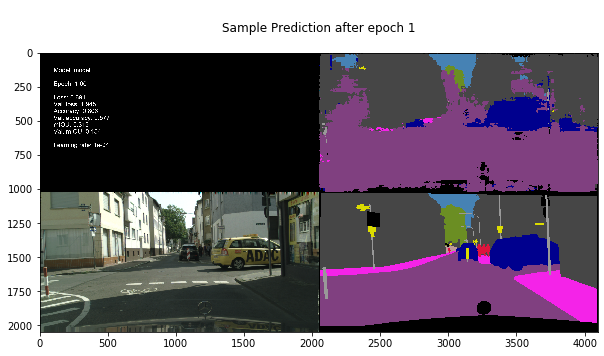


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 975s 983ms/step - loss: 0.6911 - accuracy: 0.8057 - mIOU: 0.3150 - val_loss: 1.9450 - val_accuracy: 0.5769 - val_mIOU: 0.1540
Epoch 2/50
991/991 [============================>.] - ETA: 0s - loss: 0.4378 - accuracy: 0.8614 - mIOU: 0.4395
Epoch 00002: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0002.ckpt


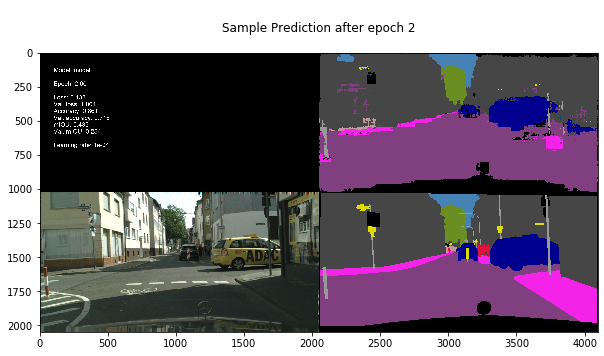


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 975s 982ms/step - loss: 0.4377 - accuracy: 0.8614 - mIOU: 0.4395 - val_loss: 1.0641 - val_accuracy: 0.7158 - val_mIOU: 0.2844
Epoch 3/50
991/991 [============================>.] - ETA: 0s - loss: 0.3866 - accuracy: 0.8746 - mIOU: 0.4870
Epoch 00003: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0003.ckpt


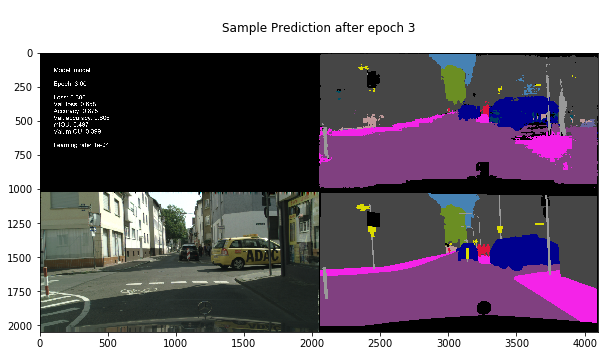


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 972s 980ms/step - loss: 0.3864 - accuracy: 0.8746 - mIOU: 0.4870 - val_loss: 0.6578 - val_accuracy: 0.8058 - val_mIOU: 0.3993
Epoch 4/50
991/991 [============================>.] - ETA: 0s - loss: 0.3590 - accuracy: 0.8820 - mIOU: 0.5182
Epoch 00004: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0004.ckpt


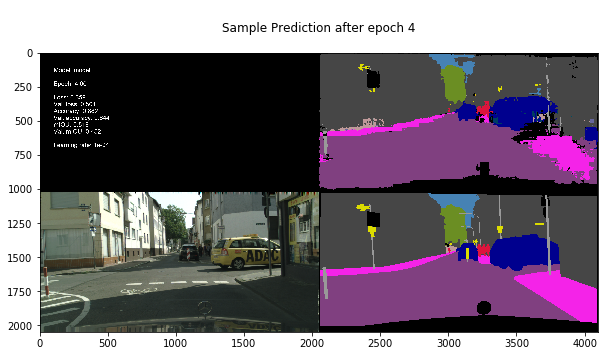


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 974s 982ms/step - loss: 0.3590 - accuracy: 0.8820 - mIOU: 0.5181 - val_loss: 0.5009 - val_accuracy: 0.8441 - val_mIOU: 0.4525
Epoch 5/50
991/991 [============================>.] - ETA: 0s - loss: 0.3385 - accuracy: 0.8876 - mIOU: 0.5408
Epoch 00005: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0005.ckpt


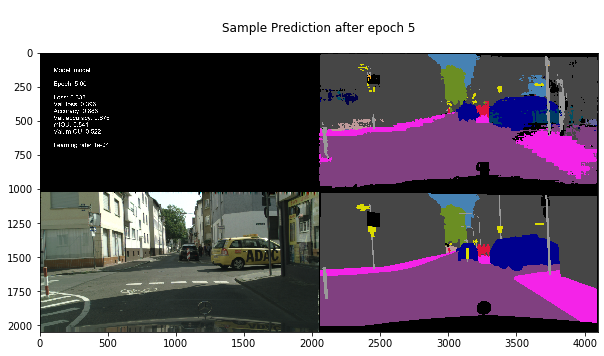


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 970s 977ms/step - loss: 0.3385 - accuracy: 0.8876 - mIOU: 0.5408 - val_loss: 0.3955 - val_accuracy: 0.8755 - val_mIOU: 0.5217
Epoch 6/50
991/991 [============================>.] - ETA: 0s - loss: 0.3244 - accuracy: 0.8917 - mIOU: 0.5598
Epoch 00006: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0006.ckpt


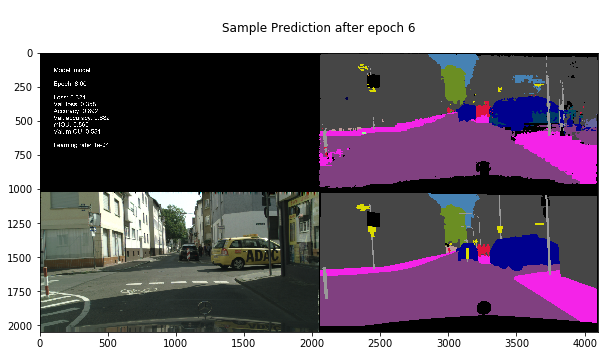


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 976s 984ms/step - loss: 0.3243 - accuracy: 0.8918 - mIOU: 0.5598 - val_loss: 0.3576 - val_accuracy: 0.8820 - val_mIOU: 0.5312
Epoch 7/50
991/991 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8962 - mIOU: 0.5758
Epoch 00007: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0007.ckpt


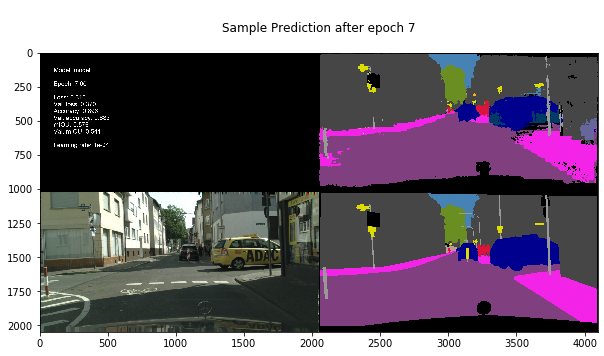


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 974s 982ms/step - loss: 0.3099 - accuracy: 0.8962 - mIOU: 0.5758 - val_loss: 0.3695 - val_accuracy: 0.8830 - val_mIOU: 0.5408
Epoch 8/50
991/991 [============================>.] - ETA: 0s - loss: 0.2984 - accuracy: 0.8994 - mIOU: 0.5916
Epoch 00008: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0008.ckpt


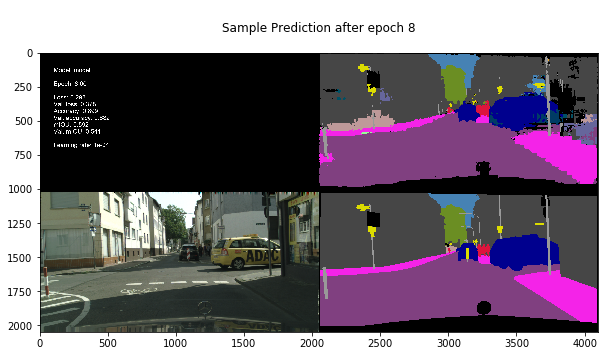


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 972s 980ms/step - loss: 0.2985 - accuracy: 0.8994 - mIOU: 0.5916 - val_loss: 0.3778 - val_accuracy: 0.8817 - val_mIOU: 0.5407
Epoch 9/50
991/991 [============================>.] - ETA: 0s - loss: 0.2878 - accuracy: 0.9026 - mIOU: 0.6061
Epoch 00009: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0009.ckpt


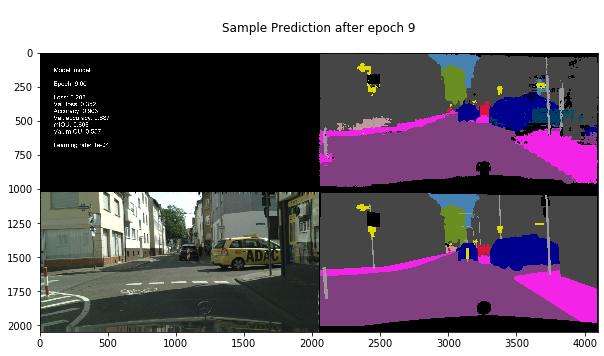


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 963s 971ms/step - loss: 0.2879 - accuracy: 0.9025 - mIOU: 0.6060 - val_loss: 0.3524 - val_accuracy: 0.8875 - val_mIOU: 0.5571
Epoch 10/50
991/991 [============================>.] - ETA: 0s - loss: 0.2831 - accuracy: 0.9040 - mIOU: 0.6126
Epoch 00010: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0010.ckpt


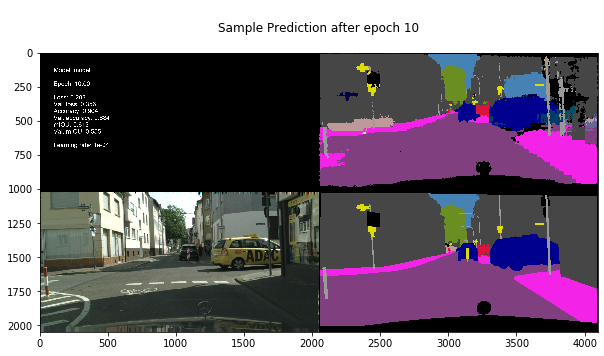


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 971s 978ms/step - loss: 0.2831 - accuracy: 0.9040 - mIOU: 0.6126 - val_loss: 0.3559 - val_accuracy: 0.8844 - val_mIOU: 0.5547
Epoch 11/50
991/991 [============================>.] - ETA: 0s - loss: 0.2754 - accuracy: 0.9064 - mIOU: 0.6231
Epoch 00011: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0011.ckpt


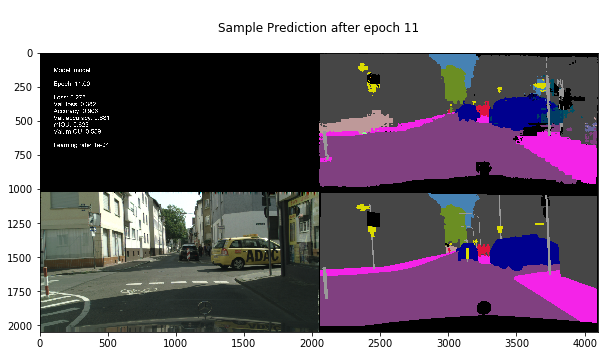


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 968s 976ms/step - loss: 0.2754 - accuracy: 0.9064 - mIOU: 0.6232 - val_loss: 0.3825 - val_accuracy: 0.8810 - val_mIOU: 0.5586
Epoch 12/50
991/991 [============================>.] - ETA: 0s - loss: 0.2685 - accuracy: 0.9083 - mIOU: 0.6337
Epoch 00012: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0012.ckpt


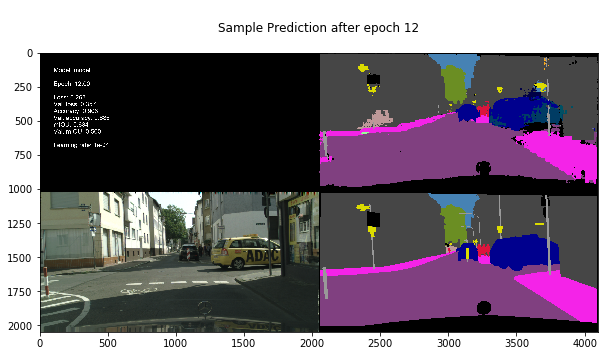


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 969s 977ms/step - loss: 0.2685 - accuracy: 0.9083 - mIOU: 0.6336 - val_loss: 0.3570 - val_accuracy: 0.8856 - val_mIOU: 0.5596
Epoch 13/50
991/991 [============================>.] - ETA: 0s - loss: 0.2619 - accuracy: 0.9106 - mIOU: 0.6417
Epoch 00013: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0013.ckpt


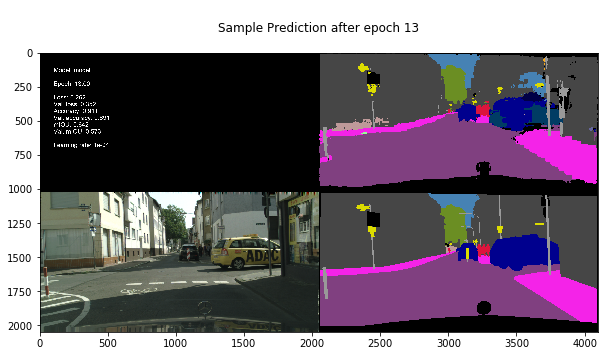


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 964s 972ms/step - loss: 0.2620 - accuracy: 0.9106 - mIOU: 0.6416 - val_loss: 0.3523 - val_accuracy: 0.8911 - val_mIOU: 0.5729
Epoch 14/50
991/991 [============================>.] - ETA: 0s - loss: 0.2583 - accuracy: 0.9115 - mIOU: 0.6505
Epoch 00014: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0014.ckpt


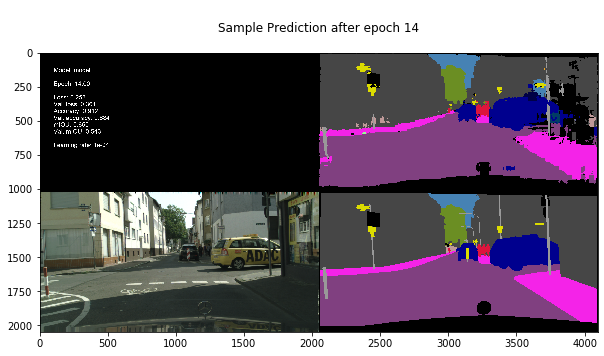


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 970s 978ms/step - loss: 0.2583 - accuracy: 0.9115 - mIOU: 0.6505 - val_loss: 0.3612 - val_accuracy: 0.8839 - val_mIOU: 0.5428
Epoch 15/50
991/991 [============================>.] - ETA: 0s - loss: 0.2498 - accuracy: 0.9143 - mIOU: 0.6588
Epoch 00015: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0015.ckpt


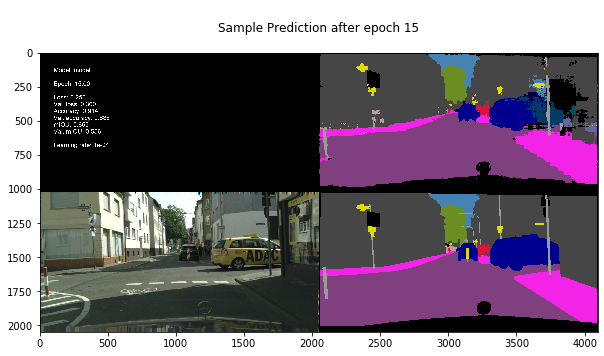


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 968s 975ms/step - loss: 0.2497 - accuracy: 0.9143 - mIOU: 0.6588 - val_loss: 0.3599 - val_accuracy: 0.8862 - val_mIOU: 0.5563
Epoch 16/50
991/991 [============================>.] - ETA: 0s - loss: 0.2448 - accuracy: 0.9158 - mIOU: 0.6645
Epoch 00016: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0016.ckpt


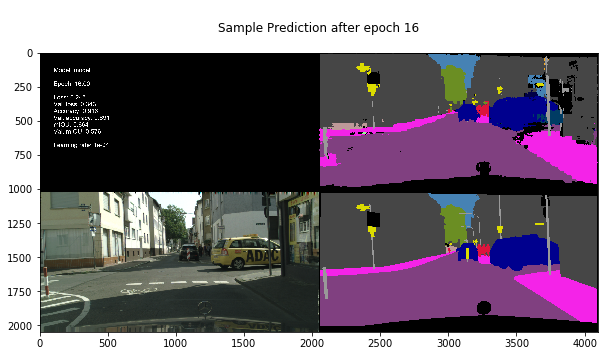


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 970s 977ms/step - loss: 0.2447 - accuracy: 0.9158 - mIOU: 0.6645 - val_loss: 0.3433 - val_accuracy: 0.8909 - val_mIOU: 0.5759
Epoch 17/50
991/991 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.9174 - mIOU: 0.6675
Epoch 00017: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0017.ckpt


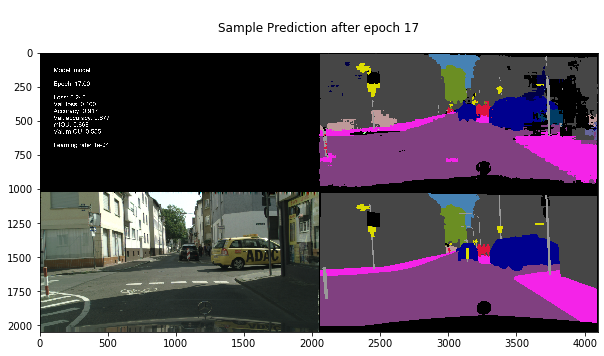


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 963s 971ms/step - loss: 0.2398 - accuracy: 0.9175 - mIOU: 0.6675 - val_loss: 0.3998 - val_accuracy: 0.8771 - val_mIOU: 0.5549
Epoch 18/50
991/991 [============================>.] - ETA: 0s - loss: 0.2369 - accuracy: 0.9184 - mIOU: 0.6786
Epoch 00018: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0018.ckpt


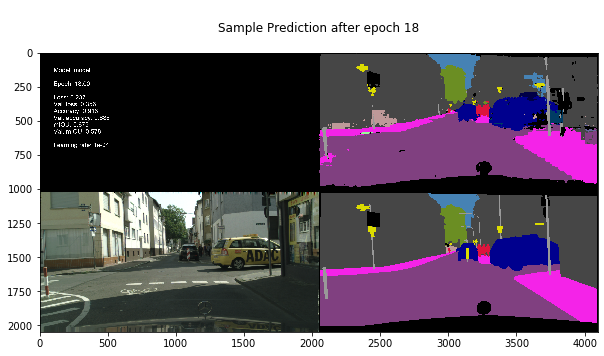


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 970s 978ms/step - loss: 0.2368 - accuracy: 0.9185 - mIOU: 0.6786 - val_loss: 0.3560 - val_accuracy: 0.8877 - val_mIOU: 0.5782
Epoch 19/50
991/991 [============================>.] - ETA: 0s - loss: 0.2330 - accuracy: 0.9194 - mIOU: 0.6778
Epoch 00019: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0019.ckpt


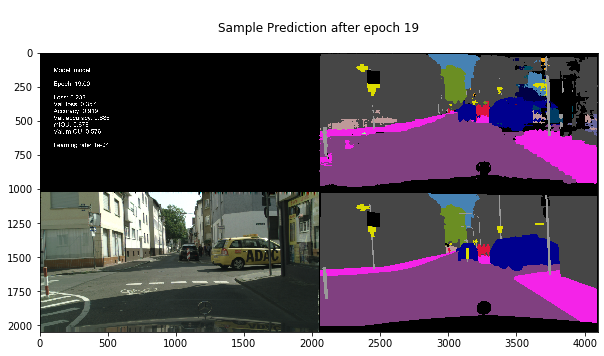


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 968s 976ms/step - loss: 0.2329 - accuracy: 0.9195 - mIOU: 0.6778 - val_loss: 0.3570 - val_accuracy: 0.8864 - val_mIOU: 0.5759
Epoch 20/50
991/991 [============================>.] - ETA: 0s - loss: 0.2268 - accuracy: 0.9219 - mIOU: 0.6920
Epoch 00020: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0020.ckpt


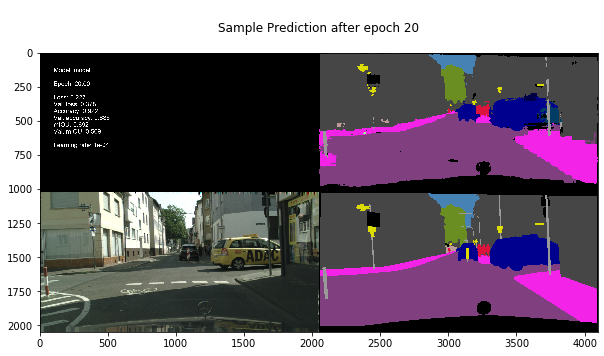


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 970s 978ms/step - loss: 0.2267 - accuracy: 0.9219 - mIOU: 0.6919 - val_loss: 0.3776 - val_accuracy: 0.8853 - val_mIOU: 0.5691
Epoch 21/50
991/991 [============================>.] - ETA: 0s - loss: 0.2238 - accuracy: 0.9227 - mIOU: 0.6926
Epoch 00021: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0021.ckpt


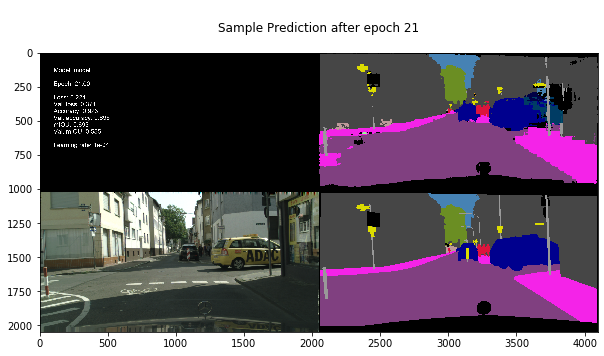


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 964s 972ms/step - loss: 0.2238 - accuracy: 0.9227 - mIOU: 0.6926 - val_loss: 0.3711 - val_accuracy: 0.8949 - val_mIOU: 0.5846
Epoch 22/50
991/991 [============================>.] - ETA: 0s - loss: 0.2219 - accuracy: 0.9236 - mIOU: 0.6975
Epoch 00022: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0022.ckpt


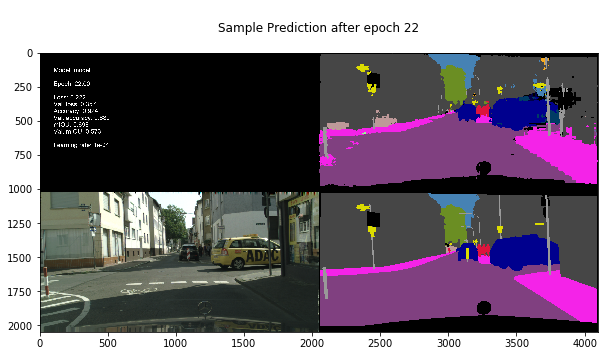


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 970s 978ms/step - loss: 0.2220 - accuracy: 0.9236 - mIOU: 0.6975 - val_loss: 0.3569 - val_accuracy: 0.8889 - val_mIOU: 0.5732
Epoch 23/50
991/991 [============================>.] - ETA: 0s - loss: 0.2173 - accuracy: 0.9249 - mIOU: 0.7011
Epoch 00023: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0023.ckpt


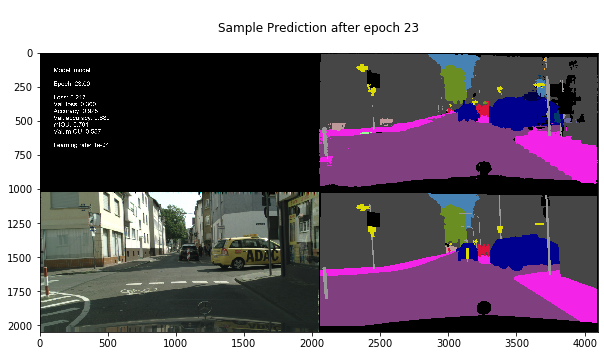


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 967s 975ms/step - loss: 0.2173 - accuracy: 0.9249 - mIOU: 0.7011 - val_loss: 0.3598 - val_accuracy: 0.8887 - val_mIOU: 0.5867
Epoch 24/50
991/991 [============================>.] - ETA: 0s - loss: 0.2122 - accuracy: 0.9265 - mIOU: 0.7065
Epoch 00024: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0024.ckpt


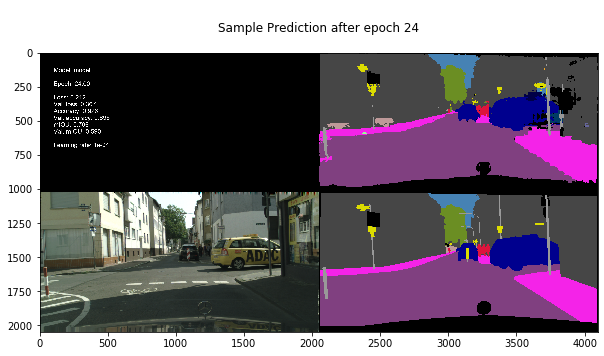


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 970s 978ms/step - loss: 0.2123 - accuracy: 0.9265 - mIOU: 0.7064 - val_loss: 0.3669 - val_accuracy: 0.8951 - val_mIOU: 0.5900
Epoch 25/50
991/991 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9270 - mIOU: 0.7091
Epoch 00025: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0025.ckpt


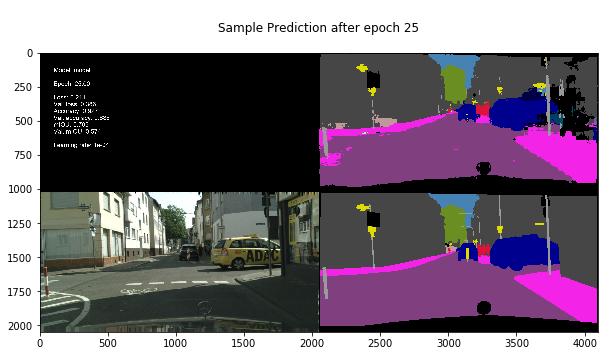


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 963s 971ms/step - loss: 0.2114 - accuracy: 0.9270 - mIOU: 0.7090 - val_loss: 0.3856 - val_accuracy: 0.8884 - val_mIOU: 0.5738
Epoch 26/50
991/991 [============================>.] - ETA: 0s - loss: 0.1979 - accuracy: 0.9314 - mIOU: 0.7264
Epoch 00026: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0026.ckpt


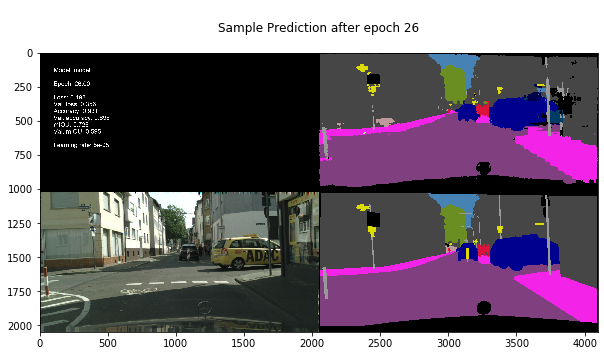


Learning rate: 4.999999873689376e-05

992/991 [==============================] - 970s 978ms/step - loss: 0.1980 - accuracy: 0.9314 - mIOU: 0.7263 - val_loss: 0.3560 - val_accuracy: 0.8979 - val_mIOU: 0.5950
Epoch 27/50
991/991 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9331 - mIOU: 0.7320
Epoch 00027: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0027.ckpt


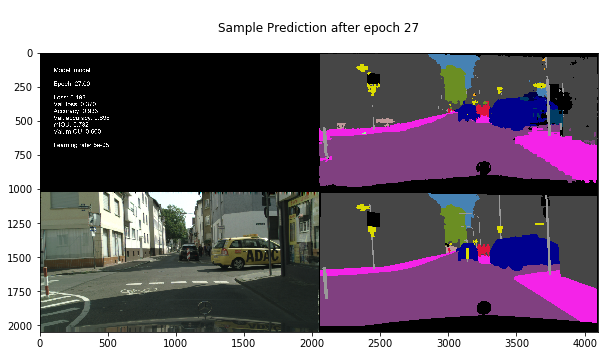


Learning rate: 4.999999873689376e-05

992/991 [==============================] - 967s 975ms/step - loss: 0.1932 - accuracy: 0.9331 - mIOU: 0.7320 - val_loss: 0.3704 - val_accuracy: 0.8983 - val_mIOU: 0.6004
Epoch 28/50
991/991 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.9337 - mIOU: 0.7339
Epoch 00028: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0028.ckpt


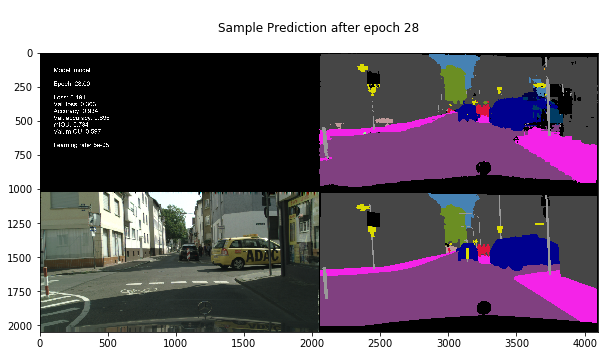


Learning rate: 4.999999873689376e-05

992/991 [==============================] - 970s 978ms/step - loss: 0.1910 - accuracy: 0.9337 - mIOU: 0.7340 - val_loss: 0.3633 - val_accuracy: 0.8964 - val_mIOU: 0.5974
Epoch 29/50
991/991 [============================>.] - ETA: 0s - loss: 0.1895 - accuracy: 0.9343 - mIOU: 0.7362
Epoch 00029: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0029.ckpt


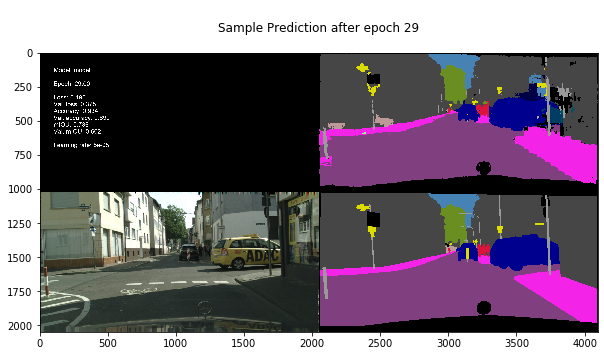


Learning rate: 4.999999873689376e-05

992/991 [==============================] - 963s 971ms/step - loss: 0.1896 - accuracy: 0.9343 - mIOU: 0.7362 - val_loss: 0.3747 - val_accuracy: 0.8988 - val_mIOU: 0.6017
Epoch 30/50
991/991 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9346 - mIOU: 0.7364
Epoch 00030: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0030.ckpt


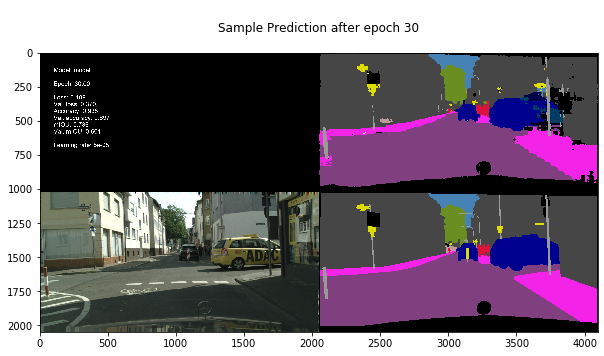


Learning rate: 4.999999873689376e-05

992/991 [==============================] - 972s 979ms/step - loss: 0.1886 - accuracy: 0.9346 - mIOU: 0.7363 - val_loss: 0.3700 - val_accuracy: 0.8966 - val_mIOU: 0.6013
Epoch 31/50
991/991 [============================>.] - ETA: 0s - loss: 0.1859 - accuracy: 0.9354 - mIOU: 0.7393
Epoch 00031: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0031.ckpt


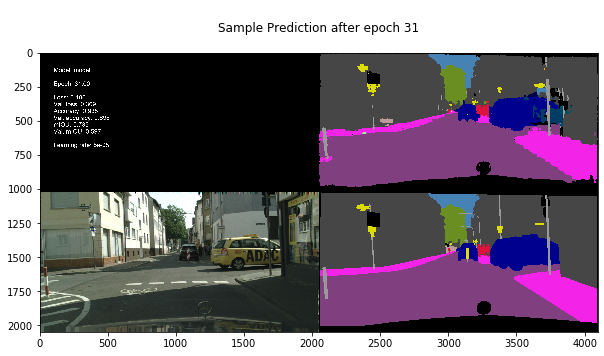


Learning rate: 4.999999873689376e-05

992/991 [==============================] - 966s 974ms/step - loss: 0.1861 - accuracy: 0.9354 - mIOU: 0.7392 - val_loss: 0.3686 - val_accuracy: 0.8983 - val_mIOU: 0.5967
Epoch 32/50
991/991 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9362 - mIOU: 0.7423
Epoch 00032: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0032.ckpt


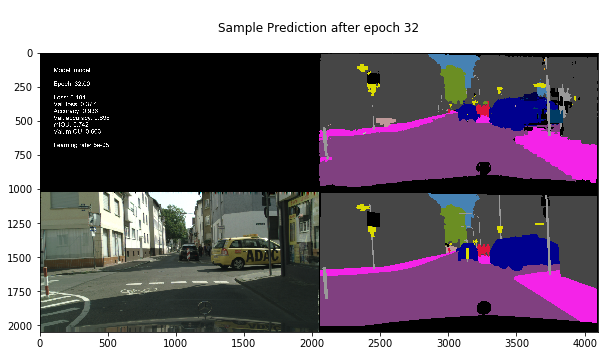


Learning rate: 4.999999873689376e-05

992/991 [==============================] - 970s 977ms/step - loss: 0.1837 - accuracy: 0.9362 - mIOU: 0.7423 - val_loss: 0.3769 - val_accuracy: 0.8982 - val_mIOU: 0.6026
Epoch 33/50
991/991 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9360 - mIOU: 0.7418
Epoch 00033: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0033.ckpt


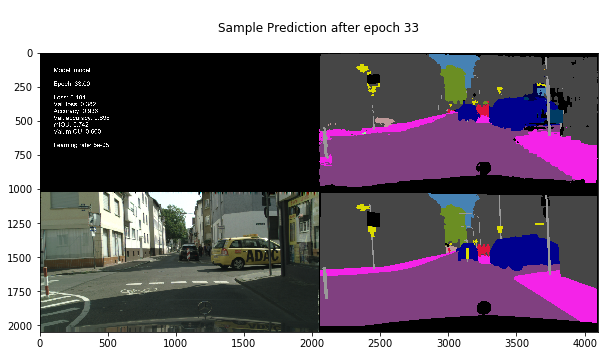


Learning rate: 4.999999873689376e-05

992/991 [==============================] - 962s 970ms/step - loss: 0.1837 - accuracy: 0.9360 - mIOU: 0.7418 - val_loss: 0.3823 - val_accuracy: 0.8984 - val_mIOU: 0.6003
Epoch 34/50
991/991 [============================>.] - ETA: 0s - loss: 0.1821 - accuracy: 0.9368 - mIOU: 0.7451
Epoch 00034: saving model to /content/drive/My Drive/MobileNetV2_LiteRASPP/ckpt/cp-0034.ckpt


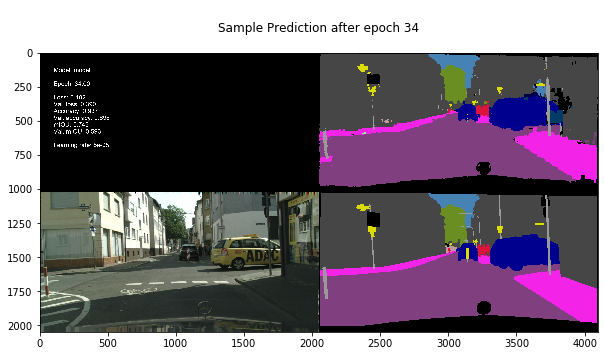


Learning rate: 4.999999873689376e-05

992/991 [==============================] - 971s 979ms/step - loss: 0.1821 - accuracy: 0.9368 - mIOU: 0.7450 - val_loss: 0.3901 - val_accuracy: 0.8978 - val_mIOU: 0.5926
Epoch 35/50
263/991 [======>.......................] - ETA: 11:15 - loss: 0.1753 - accuracy: 0.9391 - mIOU: 0.7503

In [0]:
history = model.fit(train_fine_dataset, 
                    epochs = 50*EPOCH_DIVIDER,
                    initial_epoch = 0,
                    steps_per_epoch = 2975/BATCH_SIZE/EPOCH_DIVIDER,
                    validation_data = validation_dataset, 
                    validation_steps = 500/BATCH_SIZE,
                    validation_freq = 1, 
                    class_weight=class_weights,
                    callbacks=[tensorboard_callback, 
                               checkpoint_callback, 
                               on_epoch_end_callback(),
                               learning_rate_callback,
                               print_lr_callback()])

# Inference


## Measure average time

In [0]:
import cv2

input_video_path = Path('/content/drive/My Drive/signs 46 video test.mp4')
cap = cv2.VideoCapture(str(input_video_path))

frequency = cv2.getTickFrequency()
time_log = []
fps_log = []

frames = 50
while(cap.isOpened()):
  ret, frame_FHD_BGR = cap.read()
  if ret == True:
    frame_FHD_RGB = cv2.cvtColor(frame_FHD_BGR, cv2.COLOR_BGR2RGB)
    frame_2048_RGB = tf.image.resize(frame_FHD_RGB, (IMAGE_HEIGHT, IMAGE_WIDTH), method=tf.image.ResizeMethod.BILINEAR, antialias=True)
    frame_2048_RGB = tf.cast(frame_2048_RGB, tf.float32) / 255.0

    t1 = cv2.getTickCount()
    predicted_masks_2048 = model.predict(np.expand_dims(frame_2048_RGB,0))[0]
    t2 = cv2.getTickCount()

    time = ((t2 - t1) / frequency) * 1000.0
    time_log.append(time)
    fps = 1 / (time / 1000.0)
    fps_log.append(fps)
    print('Frame: ' + str(frames), ', Time: ' + str("%.2f" % time) + 'ms, FPS: ' + str("%.2f" % fps))
    frames -= 1
  else: 
    break
  if frames <= 0:
    break

avg_fps = np.average(fps_log)
avg_time = np.average(time_log)
print('Avg. time: ' + str(avg_time) + ', Avg. FPS: ' + str(avg_fps))
cap.release()

## Process video

In [0]:
import cv2
from google.colab.patches import cv2_imshow

input_video_path = Path('/content/drive/My Drive/signs 46 video test.mp4')
output_video_path = Path('/content/out.mp4')

cap = cv2.VideoCapture(str(input_video_path))
out = cv2.VideoWriter(str(output_video_path),cv2.VideoWriter_fourcc(*'XVID'), 25, (1920, 1080))
frequency = cv2.getTickFrequency()
time_log = []
fps_log = []
font = cv2.FONT_HERSHEY_SIMPLEX
video_length = cap.get(cv2.CAP_PROP_FRAME_COUNT)

while(cap.isOpened()):
  ret, frame_FHD_BGR = cap.read()
  if ret == True:
    frame_FHD_RGB = cv2.cvtColor(frame_FHD_BGR, cv2.COLOR_BGR2RGB)
    frame_2048_RGB = tf.image.resize(frame_FHD_RGB, (IMAGE_HEIGHT, IMAGE_WIDTH), method=tf.image.ResizeMethod.BILINEAR, antialias=True)
    frame_2048_RGB = tf.cast(frame_2048_RGB, tf.float32) / 255.0

    t1 = cv2.getTickCount()
    predicted_masks_2048 = model.predict(np.expand_dims(frame_2048_RGB,0))[0]
    t2 = cv2.getTickCount()
    time = ((t2 - t1) / frequency) * 1000.0
    fps = 1 / (time / 1000.0)

    predicted_masks_2048_Y = tf.argmax(predicted_masks_2048, axis=2)
    predicted_masks_2048_RGB = color_mask(tf.cast(predicted_masks_2048_Y, tf.uint8))
    masks_FHD_RGB = tf.image.resize(predicted_masks_2048_RGB, (1080, 1920), method=tf.image.ResizeMethod.BILINEAR, antialias=True)
    output_frame_FHD_RGB = frame_FHD_RGB*0.6 + masks_FHD_RGB*0.4
    output_frame_FHD_RGB = np.uint8(output_frame_FHD_RGB)
    cv2.putText(output_frame_FHD_RGB, "Custom DeepLab V3+ MobileNet V2",(30, 50), font, 0.8, (32, 32, 32), 3, cv2.LINE_AA)
    cv2.putText(output_frame_FHD_RGB, 
                "FPS: {0:.2f}, Time: {1:.2f}ms, Avg. FPS: {2:.2f}, Avg. time: {3:.2f}ms (without preprocessing)".format(fps, time, avg_fps, avg_time), 
                (30, 100), font, 0.8, (32, 32, 32), 3, cv2.LINE_AA)
    output_frame_FHD_BGR = cv2.cvtColor(output_frame_FHD_RGB, cv2.COLOR_RGB2BGR)
    #cv2_imshow(cv2.resize(output_frame_FHD_BGR, (960, 540)))
    current_frame_num = cap.get(cv2.CAP_PROP_POS_FRAMES)
    print('Frame number: ' + str(current_frame_num) + ' / ' + str(video_length))
    out.write(output_frame_FHD_BGR)
    if current_frame_num == 100:
      break
  else: 
    break
 
cap.release()
out.release()

In [0]:
# Convert to X265
!ffmpeg -i '/content/out.mp4' -c:v libx265 -b:v 10000k -an -x265-params pass=1 OUT_x265.mp4